In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True

In [2]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 위치
data_dir1 = '../../pretrained_GNN/dataset/fruit_fresh_and_rotten_dataset'
data_dir2 = '../../pretrained_GNN/dataset/fruit_quality'
data_dir3 = '../../pretrained_GNN/dataset/fruit_quality2'

# 데이터셋 정제
image_datasets1 = {x: datasets.ImageFolder(os.path.join(data_dir1, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
image_datasets2 = {x: datasets.ImageFolder(os.path.join(data_dir2, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
image_datasets3 = {x: datasets.ImageFolder(os.path.join(data_dir3, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders1 = {x: torch.utils.data.DataLoader(image_datasets1[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataloaders2 = {x: torch.utils.data.DataLoader(image_datasets2[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataloaders3 = {x: torch.utils.data.DataLoader(image_datasets3[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}


dataset_sizes1 = {x: len(image_datasets1[x]) for x in ['train', 'val']}
dataset_sizes2 = {x: len(image_datasets2[x]) for x in ['train', 'val']}
dataset_sizes3 = {x: len(image_datasets3[x]) for x in ['train', 'val']}


class_names1 = image_datasets1['train'].classes
class_names2 = image_datasets2['train'].classes
class_names3 = image_datasets3['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(len(class_names1), len(class_names2))
print(len(class_names3))

6 12
2


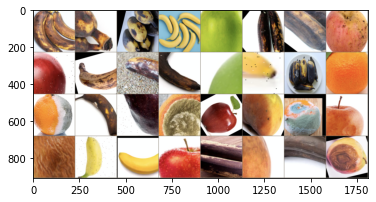

['rottenbanana', 'rottenbanana', 'rottenbanana', 'freshbanana', 'freshapples', 'rottenbanana', 'rottenbanana', 'rottenapples', 'freshapples', 'rottenbanana', 'rottenbanana', 'rottenbanana', 'freshapples', 'freshbanana', 'rottenbanana', 'freshoranges', 'rottenoranges', 'rottenbanana', 'rottenapples', 'rottenoranges', 'freshapples', 'rottenapples', 'rottenoranges', 'rottenapples', 'rottenapples', 'freshbanana', 'freshbanana', 'freshapples', 'rottenbanana', 'rottenapples', 'rottenbanana', 'rottenapples']


In [4]:
# transform 된 배치 이미지 시각화
def imshow1(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders1['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow1(out)
print([class_names1[x] for x in classes])

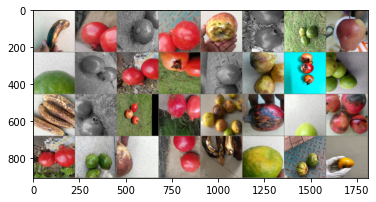

['Banana_Bad', 'Pomegranate_Good', 'Pomegranate_Good', 'Pomegranate_Good', 'Apple_Bad', 'Pomegranate_Good', 'Guava_Good', 'Apple_Good', 'Orange_Good', 'Pomegranate_Good', 'Pomegranate_Good', 'Pomegranate_Good', 'Pomegranate_Good', 'Guava_Bad', 'Pomegranate_Bad', 'Lime_Good', 'Banana_Bad', 'Pomegranate_Good', 'Pomegranate_Good', 'Pomegranate_Good', 'Lime_Bad', 'Pomegranate_Bad', 'Lime_Good', 'Pomegranate_Bad', 'Pomegranate_Good', 'Guava_Good', 'Guava_Bad', 'Pomegranate_Good', 'Banana_Bad', 'Orange_Good', 'Guava_Good', 'Orange_Bad']


In [5]:
# transform 된 배치 이미지 시각화
def imshow2(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders2['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow2(out)
print([class_names2[x] for x in classes])

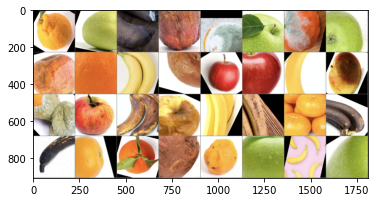

['fresh', 'fresh', 'rotten', 'rotten', 'rotten', 'fresh', 'rotten', 'fresh', 'rotten', 'fresh', 'fresh', 'rotten', 'fresh', 'fresh', 'fresh', 'rotten', 'rotten', 'rotten', 'rotten', 'rotten', 'fresh', 'rotten', 'fresh', 'rotten', 'rotten', 'fresh', 'fresh', 'rotten', 'rotten', 'fresh', 'fresh', 'fresh']


In [6]:
# transform 된 배치 이미지 시각화
def imshow3(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders3['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow1(out)
print([class_names3[x] for x in classes])

In [7]:
# dir(models)

In [8]:
# 미리 학습된 resnet 모델 불러오기
model_ft = models.mobilenet_v2(num_classes=len(class_names1))
model_ft = model_ft.to(device)

print(model_ft)
# 1/0
# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
# num_ftrs = model_ft.classifier[6].in_features
# model_ft.classifier[4] = nn.Linear(4096, 9216)
# # 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# # 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
# model_ft.classifier[6] = nn.Linear(9216, len (class_names1))
# model_ft.classifier = model_ft.classifier.to(device)

print(model_ft)
# 1/0
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [9]:
from torchsummary import summary

summary(model_ft, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [10]:
from tqdm import tqdm

def train_model1(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders1[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes1[phase]
            epoch_acc = running_corrects.double() / dataset_sizes1[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [12]:
import gc
gc.collect()
torch.cuda.empty_cache()

train_model1(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.2447 Acc: 0.9149


  5%|▌         | 1/20 [00:27<08:44, 27.59s/it]

val Loss: 0.0790 Acc: 0.9766

Epoch 1/19
----------
train Loss: 0.2466 Acc: 0.9152


 10%|█         | 2/20 [00:55<08:19, 27.76s/it]

val Loss: 0.0745 Acc: 0.9755

Epoch 2/19
----------
train Loss: 0.2461 Acc: 0.9160


 15%|█▌        | 3/20 [01:23<07:53, 27.85s/it]

val Loss: 0.0802 Acc: 0.9755

Epoch 3/19
----------
train Loss: 0.2476 Acc: 0.9114


 20%|██        | 4/20 [01:51<07:26, 27.92s/it]

val Loss: 0.0733 Acc: 0.9770

Epoch 4/19
----------
train Loss: 0.2430 Acc: 0.9143


 25%|██▌       | 5/20 [02:19<06:57, 27.82s/it]

val Loss: 0.0786 Acc: 0.9815

Epoch 5/19
----------
train Loss: 0.2401 Acc: 0.9139


 30%|███       | 6/20 [02:46<06:27, 27.68s/it]

val Loss: 0.0751 Acc: 0.9774

Epoch 6/19
----------
train Loss: 0.2438 Acc: 0.9142


 35%|███▌      | 7/20 [03:14<05:59, 27.67s/it]

val Loss: 0.0750 Acc: 0.9785

Epoch 7/19
----------
train Loss: 0.2360 Acc: 0.9169


 40%|████      | 8/20 [03:41<05:30, 27.56s/it]

val Loss: 0.0747 Acc: 0.9789

Epoch 8/19
----------
train Loss: 0.2497 Acc: 0.9145


 45%|████▌     | 9/20 [04:09<05:03, 27.63s/it]

val Loss: 0.0714 Acc: 0.9781

Epoch 9/19
----------
train Loss: 0.2457 Acc: 0.9134


 50%|█████     | 10/20 [04:36<04:36, 27.62s/it]

val Loss: 0.0748 Acc: 0.9818

Epoch 10/19
----------
train Loss: 0.2368 Acc: 0.9173


 55%|█████▌    | 11/20 [05:04<04:08, 27.58s/it]

val Loss: 0.0723 Acc: 0.9811

Epoch 11/19
----------
train Loss: 0.2385 Acc: 0.9164


 60%|██████    | 12/20 [05:31<03:40, 27.57s/it]

val Loss: 0.0777 Acc: 0.9778

Epoch 12/19
----------
train Loss: 0.2295 Acc: 0.9214


 65%|██████▌   | 13/20 [05:59<03:13, 27.60s/it]

val Loss: 0.0758 Acc: 0.9781

Epoch 13/19
----------
train Loss: 0.2457 Acc: 0.9163


 70%|███████   | 14/20 [06:27<02:45, 27.63s/it]

val Loss: 0.0726 Acc: 0.9815

Epoch 14/19
----------
train Loss: 0.2354 Acc: 0.9177


 75%|███████▌  | 15/20 [06:54<02:17, 27.59s/it]

val Loss: 0.0749 Acc: 0.9778

Epoch 15/19
----------
train Loss: 0.2370 Acc: 0.9179


 80%|████████  | 16/20 [07:22<01:50, 27.67s/it]

val Loss: 0.0754 Acc: 0.9781

Epoch 16/19
----------
train Loss: 0.2429 Acc: 0.9129


 85%|████████▌ | 17/20 [07:50<01:23, 27.70s/it]

val Loss: 0.0760 Acc: 0.9789

Epoch 17/19
----------
train Loss: 0.2354 Acc: 0.9182


 90%|█████████ | 18/20 [08:18<00:55, 27.72s/it]

val Loss: 0.0724 Acc: 0.9792

Epoch 18/19
----------
train Loss: 0.2411 Acc: 0.9173


 95%|█████████▌| 19/20 [08:45<00:27, 27.65s/it]

val Loss: 0.0796 Acc: 0.9774

Epoch 19/19
----------
train Loss: 0.2419 Acc: 0.9187


100%|██████████| 20/20 [09:13<00:00, 27.66s/it]

val Loss: 0.0751 Acc: 0.9807

Training complete in 9m 13s
Best val Acc: 0.981838


MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [16]:
model_ft = models.mobilenet_v2(num_classes=len(class_names2))
model_ft = model_ft.to(device)

# 1/0
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [17]:
from tqdm import tqdm

def train_model2(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders2[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes2[phase]
            epoch_acc = running_corrects.double() / dataset_sizes2[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [18]:
import gc
gc.collect()
torch.cuda.empty_cache()

train_model2(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 1.7818 Acc: 0.4042


  5%|▌         | 1/20 [02:04<39:26, 124.58s/it]

val Loss: 1.3441 Acc: 0.5352

Epoch 1/19
----------
train Loss: 1.2022 Acc: 0.5991


 10%|█         | 2/20 [04:04<36:37, 122.11s/it]

val Loss: 0.9008 Acc: 0.6984

Epoch 2/19
----------
train Loss: 0.8801 Acc: 0.7150


 15%|█▌        | 3/20 [06:01<33:52, 119.56s/it]

val Loss: 0.9017 Acc: 0.6703

Epoch 3/19
----------
train Loss: 0.7135 Acc: 0.7708


 20%|██        | 4/20 [08:02<32:00, 120.00s/it]

val Loss: 0.8142 Acc: 0.7453

Epoch 4/19
----------
train Loss: 0.6253 Acc: 0.7985


 25%|██▌       | 5/20 [10:03<30:06, 120.43s/it]

val Loss: 0.8682 Acc: 0.7190

Epoch 5/19
----------
train Loss: 0.5562 Acc: 0.8200


 30%|███       | 6/20 [12:06<28:20, 121.49s/it]

val Loss: 0.8346 Acc: 0.7458

Epoch 6/19
----------
train Loss: 0.4929 Acc: 0.8400


 35%|███▌      | 7/20 [14:07<26:17, 121.33s/it]

val Loss: 0.8303 Acc: 0.7547

Epoch 7/19
----------
train Loss: 0.4106 Acc: 0.8648


 40%|████      | 8/20 [16:09<24:17, 121.48s/it]

val Loss: 0.7730 Acc: 0.7818

Epoch 8/19
----------
train Loss: 0.3722 Acc: 0.8804


 45%|████▌     | 9/20 [18:11<22:18, 121.65s/it]

val Loss: 0.7016 Acc: 0.7962

Epoch 9/19
----------
train Loss: 0.3626 Acc: 0.8858


 50%|█████     | 10/20 [20:16<20:26, 122.62s/it]

val Loss: 0.6963 Acc: 0.7978

Epoch 10/19
----------
train Loss: 0.3508 Acc: 0.8880


 55%|█████▌    | 11/20 [22:21<18:30, 123.34s/it]

val Loss: 0.6357 Acc: 0.8018

Epoch 11/19
----------
train Loss: 0.3441 Acc: 0.8914


 60%|██████    | 12/20 [24:24<16:25, 123.20s/it]

val Loss: 0.7102 Acc: 0.7943

Epoch 12/19
----------
train Loss: 0.3217 Acc: 0.9001


 65%|██████▌   | 13/20 [26:28<14:24, 123.51s/it]

val Loss: 0.6790 Acc: 0.7959

Epoch 13/19
----------
train Loss: 0.3171 Acc: 0.8979


 70%|███████   | 14/20 [28:28<12:15, 122.51s/it]

val Loss: 0.7078 Acc: 0.7916

Epoch 14/19
----------
train Loss: 0.3212 Acc: 0.8978


 75%|███████▌  | 15/20 [30:27<10:06, 121.27s/it]

val Loss: 0.6679 Acc: 0.8008

Epoch 15/19
----------
train Loss: 0.3161 Acc: 0.8941


 80%|████████  | 16/20 [32:27<08:04, 121.07s/it]

val Loss: 0.6457 Acc: 0.8016

Epoch 16/19
----------
train Loss: 0.3106 Acc: 0.9001


 85%|████████▌ | 17/20 [34:31<06:05, 121.72s/it]

val Loss: 0.6642 Acc: 0.7994

Epoch 17/19
----------
train Loss: 0.3143 Acc: 0.8992


 90%|█████████ | 18/20 [36:33<04:04, 122.03s/it]

val Loss: 0.7093 Acc: 0.8008

Epoch 18/19
----------
train Loss: 0.3091 Acc: 0.9005


 95%|█████████▌| 19/20 [38:36<02:02, 122.31s/it]

val Loss: 0.6507 Acc: 0.8037

Epoch 19/19
----------
train Loss: 0.3155 Acc: 0.9006


100%|██████████| 20/20 [40:41<00:00, 122.08s/it]

val Loss: 0.6787 Acc: 0.8018

Training complete in 40m 42s
Best val Acc: 0.803736


MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [19]:
model_ft = models.mobilenet_v2(num_classes=len(class_names3))
model_ft = model_ft.to(device)

# 1/0
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [20]:
from tqdm import tqdm

def train_model3(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders3[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes3[phase]
            epoch_acc = running_corrects.double() / dataset_sizes3[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [21]:
import gc
gc.collect()
torch.cuda.empty_cache()

train_model3(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.4230 Acc: 0.7973


  5%|▌         | 1/20 [00:35<11:12, 35.40s/it]

val Loss: 0.3667 Acc: 0.8262

Epoch 1/19
----------
train Loss: 0.2992 Acc: 0.8765


 10%|█         | 2/20 [01:10<10:34, 35.24s/it]

val Loss: 0.1895 Acc: 0.9305

Epoch 2/19
----------
train Loss: 0.2864 Acc: 0.8805


 15%|█▌        | 3/20 [01:45<09:59, 35.26s/it]

val Loss: 0.1739 Acc: 0.9387

Epoch 3/19
----------
train Loss: 0.2388 Acc: 0.9060


 20%|██        | 4/20 [02:20<09:21, 35.07s/it]

val Loss: 0.1537 Acc: 0.9442

Epoch 4/19
----------
train Loss: 0.2527 Acc: 0.8962


 25%|██▌       | 5/20 [02:55<08:45, 35.05s/it]

val Loss: 0.1399 Acc: 0.9451

Epoch 5/19
----------
train Loss: 0.2354 Acc: 0.9051


 30%|███       | 6/20 [03:31<08:13, 35.26s/it]

val Loss: 0.1308 Acc: 0.9534

Epoch 6/19
----------
train Loss: 0.2131 Acc: 0.9132


 35%|███▌      | 7/20 [04:06<07:38, 35.27s/it]

val Loss: 0.1107 Acc: 0.9582

Epoch 7/19
----------
train Loss: 0.1775 Acc: 0.9298


 40%|████      | 8/20 [04:42<07:06, 35.56s/it]

val Loss: 0.0919 Acc: 0.9679

Epoch 8/19
----------
train Loss: 0.1770 Acc: 0.9295


 45%|████▌     | 9/20 [05:17<06:29, 35.40s/it]

val Loss: 0.0836 Acc: 0.9747

Epoch 9/19
----------
train Loss: 0.1743 Acc: 0.9315


 50%|█████     | 10/20 [05:53<05:55, 35.52s/it]

val Loss: 0.0863 Acc: 0.9721

Epoch 10/19
----------
train Loss: 0.1649 Acc: 0.9338


 55%|█████▌    | 11/20 [06:29<05:19, 35.54s/it]

val Loss: 0.0745 Acc: 0.9761

Epoch 11/19
----------
train Loss: 0.1628 Acc: 0.9368


 60%|██████    | 12/20 [07:04<04:43, 35.48s/it]

val Loss: 0.0744 Acc: 0.9763

Epoch 12/19
----------
train Loss: 0.1596 Acc: 0.9373


 65%|██████▌   | 13/20 [07:39<04:06, 35.28s/it]

val Loss: 0.0680 Acc: 0.9793

Epoch 13/19
----------
train Loss: 0.1515 Acc: 0.9422


 70%|███████   | 14/20 [08:14<03:31, 35.28s/it]

val Loss: 0.0746 Acc: 0.9743

Epoch 14/19
----------
train Loss: 0.1445 Acc: 0.9427


 75%|███████▌  | 15/20 [08:50<02:56, 35.38s/it]

val Loss: 0.0670 Acc: 0.9771

Epoch 15/19
----------
train Loss: 0.1533 Acc: 0.9378


 80%|████████  | 16/20 [09:25<02:20, 35.22s/it]

val Loss: 0.0649 Acc: 0.9785

Epoch 16/19
----------
train Loss: 0.1493 Acc: 0.9406


 85%|████████▌ | 17/20 [10:00<01:45, 35.22s/it]

val Loss: 0.0706 Acc: 0.9774

Epoch 17/19
----------
train Loss: 0.1496 Acc: 0.9401


 90%|█████████ | 18/20 [10:35<01:10, 35.27s/it]

val Loss: 0.0683 Acc: 0.9778

Epoch 18/19
----------
train Loss: 0.1399 Acc: 0.9460


 95%|█████████▌| 19/20 [11:10<00:35, 35.12s/it]

val Loss: 0.0631 Acc: 0.9796

Epoch 19/19
----------
train Loss: 0.1502 Acc: 0.9437


100%|██████████| 20/20 [11:45<00:00, 35.26s/it]

val Loss: 0.0697 Acc: 0.9783

Training complete in 11m 45s
Best val Acc: 0.979633


MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [2]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 위치
data_dir = '../../pretrained_GNN/dataset/FruitAndVegetables'


# 데이터셋 정제
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# 미리 학습된 resnet 모델 불러오기
model_ft = models.mobilenet_v2(num_classes=len(class_names))
model_ft = model_ft.to(device)

print(model_ft)
# 1/0
# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
# num_ftrs = model_ft.classifier[6].in_features
# model_ft.classifier[4] = nn.Linear(4096, 9216)
# # 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# # 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
# model_ft.classifier[6] = nn.Linear(9216, len (class_names1))
# model_ft.classifier = model_ft.classifier.to(device)

print(model_ft)
# 1/0
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

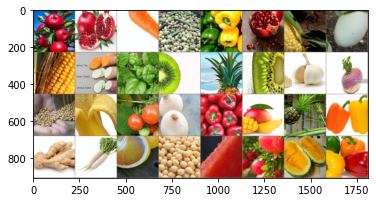

['apple', 'pomegranate', 'carrot', 'peas', 'bell pepper', 'pomegranate', 'corn', 'eggplant', 'corn', 'sweetpotato', 'spinach', 'kiwi', 'pineapple', 'kiwi', 'garlic', 'turnip', 'soy beans', 'banana', 'tomato', 'onion', 'paprika', 'mango', 'pineapple', 'capsicum', 'ginger', 'raddish', 'mango', 'soy beans', 'watermelon', 'pomegranate', 'watermelon', 'bell pepper']


In [14]:
# transform 된 배치 이미지 시각화
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out)
print([class_names[x] for x in classes])

In [4]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.001)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()

train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.3992 Acc: 0.2925


  5%|▌         | 1/20 [01:02<19:39, 62.10s/it]

val Loss: 1.8702 Acc: 0.4847

Epoch 1/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4268 Acc: 0.2986


 10%|█         | 2/20 [02:04<18:41, 62.33s/it]

val Loss: 1.8683 Acc: 0.4596

Epoch 2/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.3777 Acc: 0.2963


 15%|█▌        | 3/20 [03:07<17:47, 62.79s/it]

val Loss: 1.8661 Acc: 0.4819

Epoch 3/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4059 Acc: 0.2937


 20%|██        | 4/20 [04:10<16:40, 62.52s/it]

val Loss: 1.8793 Acc: 0.4540

Epoch 4/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.3944 Acc: 0.2960


 25%|██▌       | 5/20 [05:12<15:35, 62.35s/it]

val Loss: 1.8887 Acc: 0.4429

Epoch 5/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4039 Acc: 0.2986


 30%|███       | 6/20 [06:15<14:36, 62.61s/it]

val Loss: 1.8738 Acc: 0.4763

Epoch 6/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4186 Acc: 0.2899


 35%|███▌      | 7/20 [07:17<13:34, 62.64s/it]

val Loss: 1.9175 Acc: 0.4847

Epoch 7/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.3985 Acc: 0.2963


 40%|████      | 8/20 [08:21<12:35, 62.94s/it]

val Loss: 1.8726 Acc: 0.4596

Epoch 8/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4175 Acc: 0.2848


 45%|████▌     | 9/20 [09:25<11:34, 63.16s/it]

val Loss: 1.8710 Acc: 0.5014

Epoch 9/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4010 Acc: 0.2970


 50%|█████     | 10/20 [10:26<10:27, 62.72s/it]

val Loss: 1.8595 Acc: 0.4652

Epoch 10/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4079 Acc: 0.2931


 55%|█████▌    | 11/20 [11:33<09:34, 63.83s/it]

val Loss: 1.8763 Acc: 0.4540

Epoch 11/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4023 Acc: 0.2876


 60%|██████    | 12/20 [12:35<08:26, 63.36s/it]

val Loss: 1.8844 Acc: 0.4708

Epoch 12/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4043 Acc: 0.2905


 65%|██████▌   | 13/20 [13:36<07:18, 62.64s/it]

val Loss: 1.8808 Acc: 0.4540

Epoch 13/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.3888 Acc: 0.2998


 70%|███████   | 14/20 [14:35<06:09, 61.66s/it]

val Loss: 1.8796 Acc: 0.4875

Epoch 14/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.3990 Acc: 0.2909


 75%|███████▌  | 15/20 [15:35<05:04, 60.98s/it]

val Loss: 1.8705 Acc: 0.4735

Epoch 15/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4232 Acc: 0.2979


 80%|████████  | 16/20 [16:37<04:05, 61.44s/it]

val Loss: 1.8776 Acc: 0.4791

Epoch 16/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4284 Acc: 0.2854


 85%|████████▌ | 17/20 [17:38<03:03, 61.26s/it]

val Loss: 1.8857 Acc: 0.4596

Epoch 17/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.3819 Acc: 0.3014


 90%|█████████ | 18/20 [18:39<02:02, 61.03s/it]

val Loss: 1.8648 Acc: 0.4735

Epoch 18/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.4098 Acc: 0.2902


 95%|█████████▌| 19/20 [19:39<01:00, 60.84s/it]

val Loss: 1.8695 Acc: 0.4680

Epoch 19/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.3945 Acc: 0.3040


100%|██████████| 20/20 [20:40<00:00, 62.03s/it]

val Loss: 1.8652 Acc: 0.4680

Training complete in 20m 41s
Best val Acc: 0.501393


MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,